In [1]:
import boto3
import botocore
from IPython.core.display import display, HTML
from iterdub import iterdub as ib
from iterpop import iterpop as ip
import itertools as it
import json
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object
from scipy import stats
import seaborn as sns
from teeplot import teeplot as tp
from tqdm.notebook import tqdm

In [2]:
from dishpylib.pyanalysis import calc_loglikelihoods_by_num_sets
from dishpylib.pyanalysis import count_hands_with_k_or_more_sets
from dishpylib.pyanalysis import count_hands_without_k_or_more_sets
from dishpylib.pyanalysis import estimate_interpolation_complexity
from dishpylib.pyanalysis import calc_loglikelihoods_over_set_sizes
from dishpylib.pyhelpers import get_control_t_distns

# get control data

In [3]:
control_fits_df = get_control_t_distns('prq49', 16, 40)

# get data

In [4]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

series_profiles, = bucket_handle.objects.filter(
    Prefix=f'endeavor=16/noncritical-phenotypeneutral-nopinterpolation-competitions/stage=6+what=collated/stint=40',
)

In [5]:
df = pd.read_csv(
    f's3://prq49/{series_profiles.key}',
    compression='xz',
)
dfdigest = '{:x}'.format( hash_pandas_object( df ).sum() )
dfdigest

'-7517923449d93617'

# preprocess data

In [6]:
h0_fit = lambda series: ip.popsingleton( control_fits_df[
    control_fits_df['Series'] == series
].to_dict(
    orient='records',
) )

df['p'] =  df.apply(
    lambda row: stats.t.cdf(
        row['Fitness Differential'],
        h0_fit(row['genome series'])['Fit Degrees of Freedom'],
        loc=h0_fit(row['genome series'])['Fit Loc'],
        scale=h0_fit(row['genome series'])['Fit Scale'],
    ),
    axis=1,
)

In [7]:
df['Is Less Fit'] = df['p'] < 1.0 / 500

In [8]:
df['Is More Fit'] = df['p'] > (1.0 - 1.0 / 500)

In [9]:
df['Relative Fitness'] = df.apply( 
    lambda row: \
        'Significantly Advantageous' if row['p'] > (1.0 - 1.0 / 100) \
        else 'Significantly Deleterious' if row['p'] < 1.0 / 100 \
        else 'Neutral',
    axis=1,
)

# summarize data and model fitting

In [10]:
def log_lineplot(*args, **kwargs):
    sns.lineplot(*args, **kwargs)
    plt.yscale('log')
    plt.autoscale()

def lineplot_scatterplot(*args, **kwargs):
    sns.lineplot(
        *args,
        **{k : v for k, v in kwargs.items() if k != 'hue'},
        color='gray',
        zorder=1,
    )
    sns.scatterplot(
        *args,
        **kwargs,
        palette={
            'Significantly Advantageous' : sns.color_palette()[2],
            'Neutral' : sns.color_palette()[0],
            'Significantly Deleterious' : sns.color_palette()[1],
        },
        zorder=2,
    )
    plt.legend(
        handles=[
            matplotlib.patches.Patch(
                color=sns.color_palette()[2], 
                label='Significantly Advantageous',
            ),
            matplotlib.patches.Patch(
                color=sns.color_palette()[0],
                label='Neutral',
            ),
            matplotlib.patches.Patch(
                color=sns.color_palette()[1],
                label='Significantly Deleterious',
            ),
        ],
    )


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


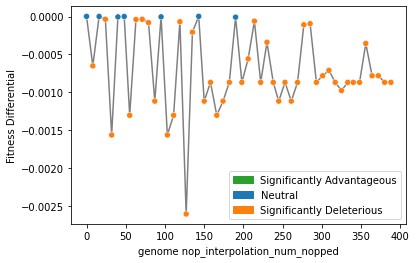

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


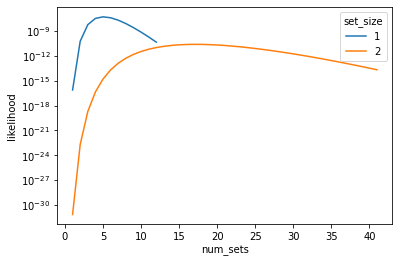

{
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 17,
    "a=most_credible_likelihood+set_size=1": 4.950386356642954e-08,
    "a=most_credible_likelihood+set_size=2": 2.3901241491221503e-11,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 8,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 4.950386356642954e-08,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


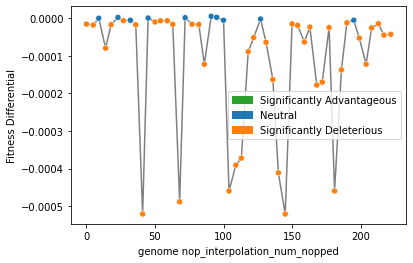

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


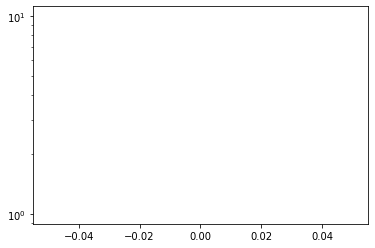

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


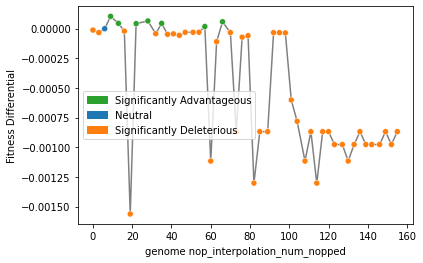

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


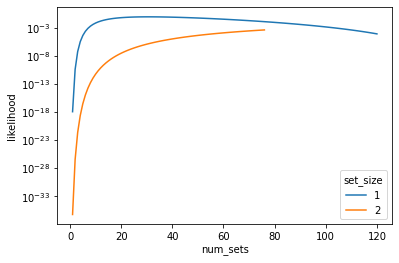

{
    "a=most_credible_idx+set_size=1": 31,
    "a=most_credible_idx+set_size=2": 76,
    "a=most_credible_likelihood+set_size=1": 0.1002070498342817,
    "a=most_credible_likelihood+set_size=2": 0.0004650663871172073,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 12,
    "credible_interval_upper_bound_idx": 75,
    "interpolation_complexity": 31,
    "most_credible_idx": 31,
    "most_credible_likelihood": 0.1002070498342817,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


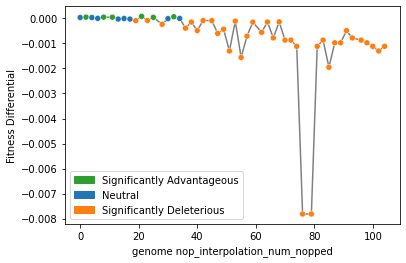

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


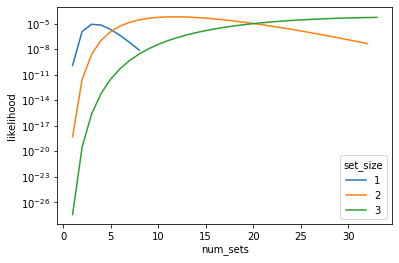

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 12,
    "a=most_credible_idx+set_size=3": 33,
    "a=most_credible_likelihood+set_size=1": 8.526558866761699e-06,
    "a=most_credible_likelihood+set_size=2": 6.352772984969724e-05,
    "a=most_credible_likelihood+set_size=3": 5.505593887485353e-05,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 7,
    "credible_interval_upper_bound_idx": 20,
    "interpolation_complexity": 12,
    "most_credible_idx": 12,
    "most_credible_likelihood": 6.352772984969724e-05,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


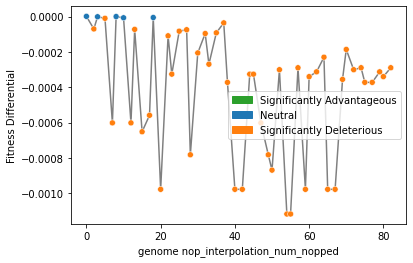

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


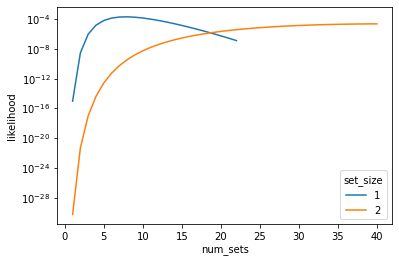

{
    "a=most_credible_idx+set_size=1": 8,
    "a=most_credible_idx+set_size=2": 40,
    "a=most_credible_likelihood+set_size=1": 0.00019251299394689185,
    "a=most_credible_likelihood+set_size=2": 2.204739580678035e-05,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 5,
    "credible_interval_upper_bound_idx": 14,
    "interpolation_complexity": 8,
    "most_credible_idx": 8,
    "most_credible_likelihood": 0.00019251299394689185,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


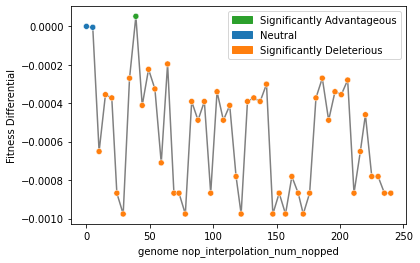

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


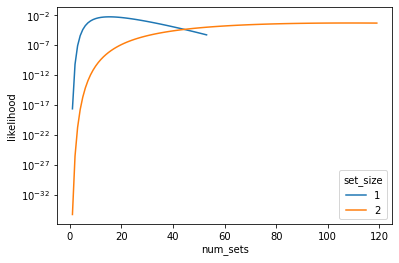

{
    "a=most_credible_idx+set_size=1": 15,
    "a=most_credible_idx+set_size=2": 109,
    "a=most_credible_likelihood+set_size=1": 0.0057722539655891214,
    "a=most_credible_likelihood+set_size=2": 0.0005367599304457939,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 8,
    "credible_interval_upper_bound_idx": 32,
    "interpolation_complexity": 15,
    "most_credible_idx": 15,
    "most_credible_likelihood": 0.0057722539655891214,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


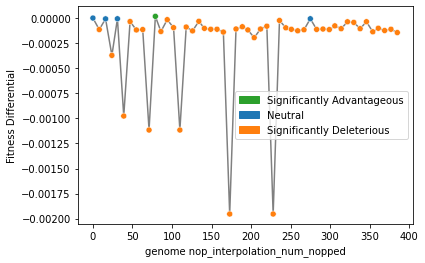

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


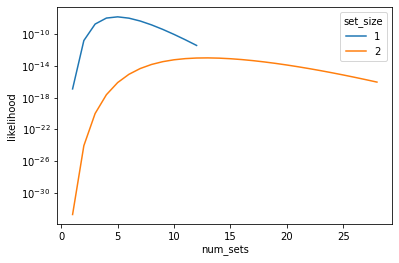

{
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 13,
    "a=most_credible_likelihood+set_size=1": 1.3716985226667414e-08,
    "a=most_credible_likelihood+set_size=2": 9.489494061218198e-14,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 7,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 1.3716985226667414e-08,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


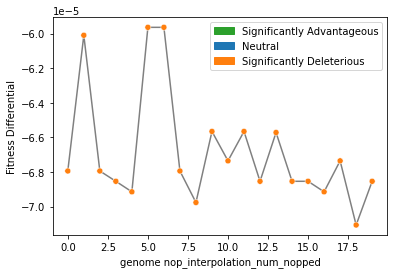

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


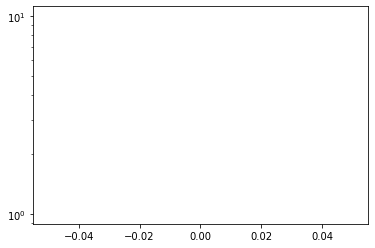

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


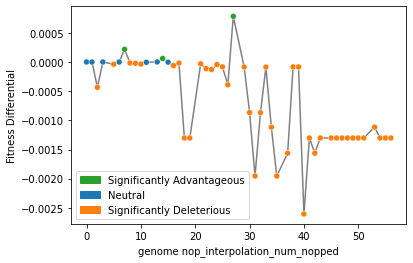

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


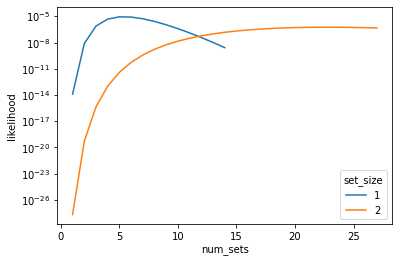

{
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 23,
    "a=most_credible_likelihood+set_size=1": 8.796270582145311e-06,
    "a=most_credible_likelihood+set_size=2": 5.742347198863929e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 9,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 8.796270582145311e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


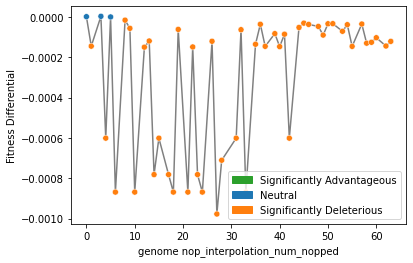

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


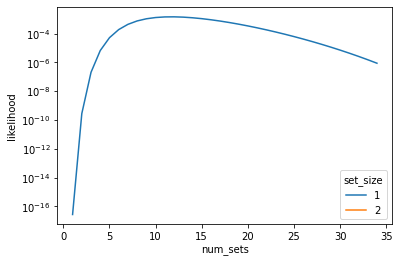

{
    "a=most_credible_idx+set_size=1": 12,
    "a=most_credible_idx+set_size=2": NaN,
    "a=most_credible_likelihood+set_size=1": 0.0014807180596583826,
    "a=most_credible_likelihood+set_size=2": NaN,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 6,
    "credible_interval_upper_bound_idx": 21,
    "interpolation_complexity": 12,
    "most_credible_idx": 12,
    "most_credible_likelihood": 0.0014807180596583826,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


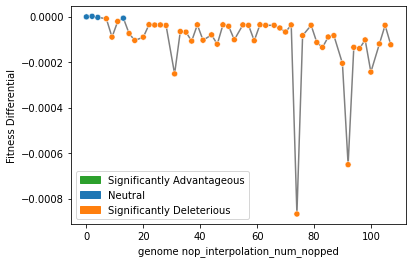

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


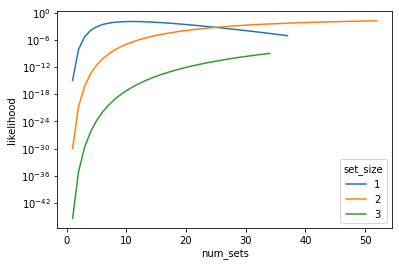

{
    "a=most_credible_idx+set_size=1": 11,
    "a=most_credible_idx+set_size=2": 52,
    "a=most_credible_idx+set_size=3": 34,
    "a=most_credible_likelihood+set_size=1": 0.012112559094452576,
    "a=most_credible_likelihood+set_size=2": 0.016940052282386917,
    "a=most_credible_likelihood+set_size=3": 1.0546014694064555e-09,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 31,
    "credible_interval_upper_bound_idx": 52,
    "interpolation_complexity": 52,
    "most_credible_idx": 52,
    "most_credible_likelihood": 0.016940052282386917,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


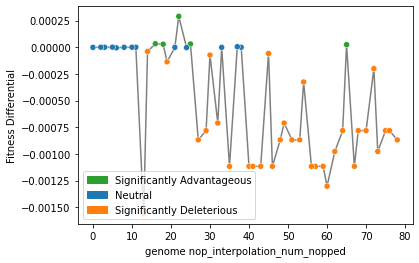

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


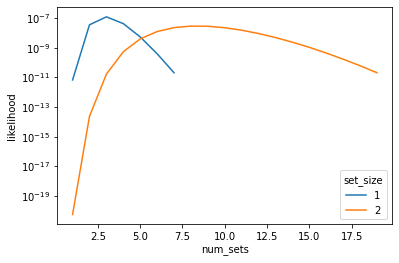

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 8,
    "a=most_credible_likelihood+set_size=1": 1.2193618263344055e-07,
    "a=most_credible_likelihood+set_size=2": 2.886703902978332e-08,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 4,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 1.2193618263344055e-07,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


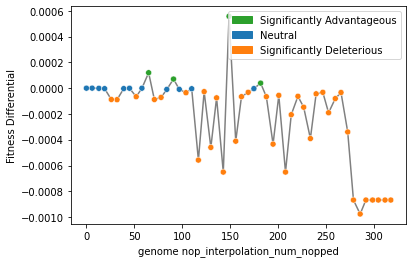

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


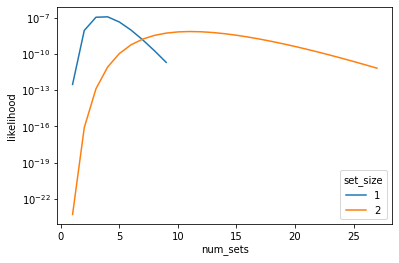

{
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 11,
    "a=most_credible_likelihood+set_size=1": 1.1570799138546991e-07,
    "a=most_credible_likelihood+set_size=2": 7.0638695120520846e-09,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 6,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 1.1570799138546991e-07,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


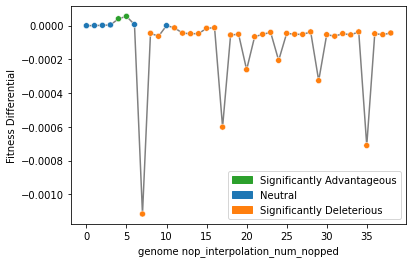

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


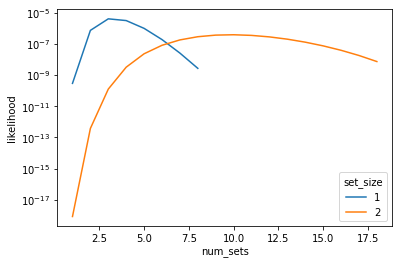

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 10,
    "a=most_credible_likelihood+set_size=1": 3.973340949251909e-06,
    "a=most_credible_likelihood+set_size=2": 3.7990385226102734e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 5,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 3.973340949251909e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


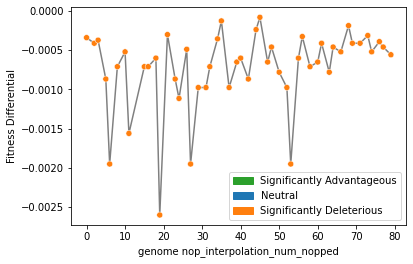

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


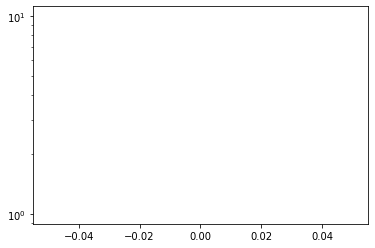

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


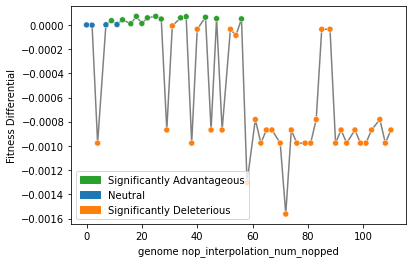

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


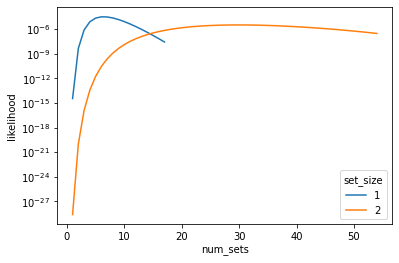

{
    "a=most_credible_idx+set_size=1": 6,
    "a=most_credible_idx+set_size=2": 30,
    "a=most_credible_likelihood+set_size=1": 3.163754533466081e-05,
    "a=most_credible_likelihood+set_size=2": 3.2598724375834873e-06,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 11,
    "interpolation_complexity": 6,
    "most_credible_idx": 6,
    "most_credible_likelihood": 3.163754533466081e-05,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


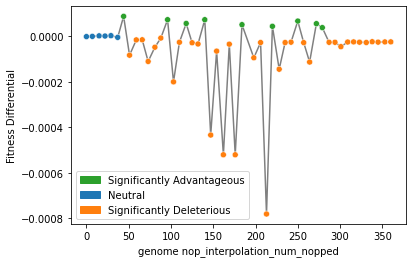

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


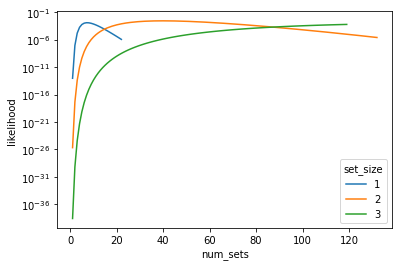

{
    "a=most_credible_idx+set_size=1": 7,
    "a=most_credible_idx+set_size=2": 40,
    "a=most_credible_idx+set_size=3": 119,
    "a=most_credible_likelihood+set_size=1": 0.0011917796380986828,
    "a=most_credible_likelihood+set_size=2": 0.0026197240119438486,
    "a=most_credible_likelihood+set_size=3": 0.0005832421350416883,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 19,
    "credible_interval_upper_bound_idx": 80,
    "interpolation_complexity": 40,
    "most_credible_idx": 40,
    "most_credible_likelihood": 0.0026197240119438486,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


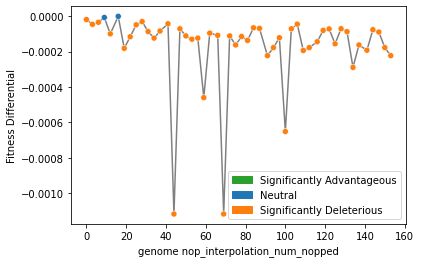

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


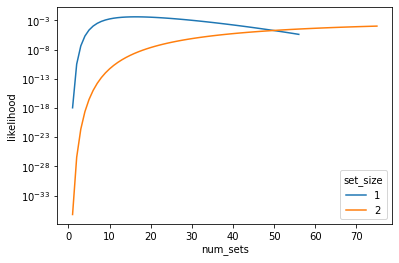

{
    "a=most_credible_idx+set_size=1": 16,
    "a=most_credible_idx+set_size=2": 75,
    "a=most_credible_likelihood+set_size=1": 0.004171728889385781,
    "a=most_credible_likelihood+set_size=2": 0.00010776838197095864,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 8,
    "credible_interval_upper_bound_idx": 34,
    "interpolation_complexity": 16,
    "most_credible_idx": 16,
    "most_credible_likelihood": 0.004171728889385781,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


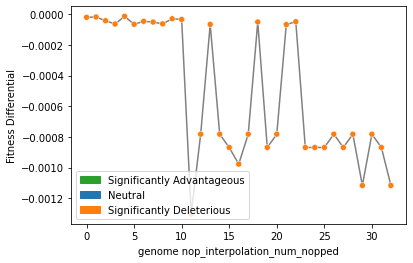

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


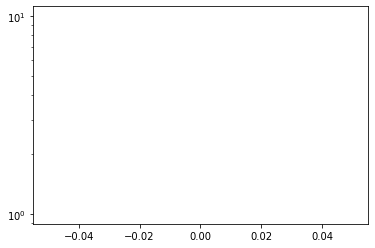

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


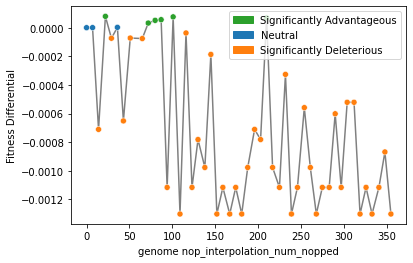

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


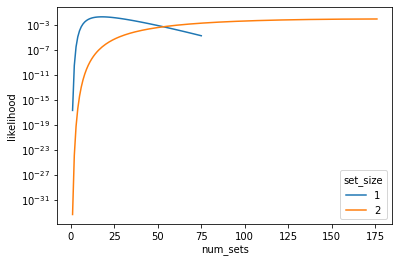

{
    "a=most_credible_idx+set_size=1": 18,
    "a=most_credible_idx+set_size=2": 176,
    "a=most_credible_likelihood+set_size=1": 0.022276081457056878,
    "a=most_credible_likelihood+set_size=2": 0.010093489084384778,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 8,
    "credible_interval_upper_bound_idx": 42,
    "interpolation_complexity": 18,
    "most_credible_idx": 18,
    "most_credible_likelihood": 0.022276081457056878,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


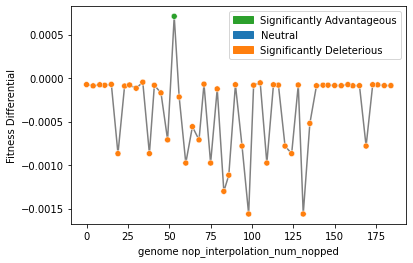

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


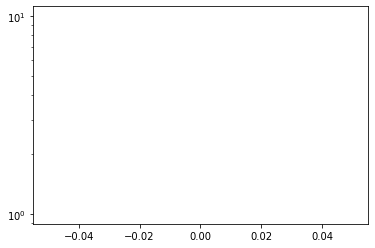

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


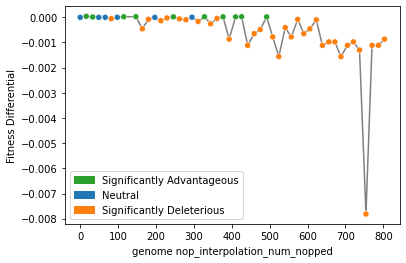

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


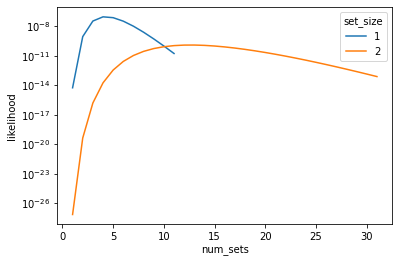

{
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 13,
    "a=most_credible_likelihood+set_size=1": 8.809739148970221e-08,
    "a=most_credible_likelihood+set_size=2": 1.1914446838864555e-10,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 7,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 8.809739148970221e-08,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


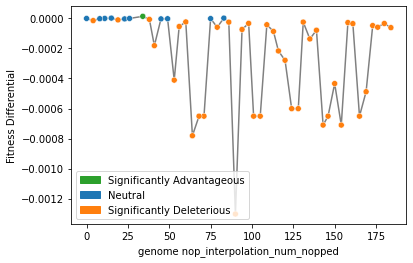

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


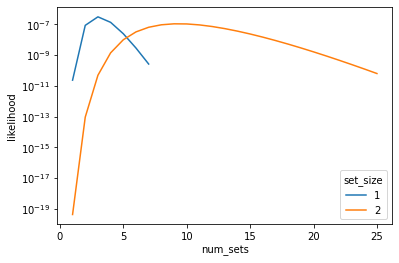

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 9,
    "a=most_credible_likelihood+set_size=1": 3.081898855540865e-07,
    "a=most_credible_likelihood+set_size=2": 1.0837775649649986e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 4,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 3.081898855540865e-07,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


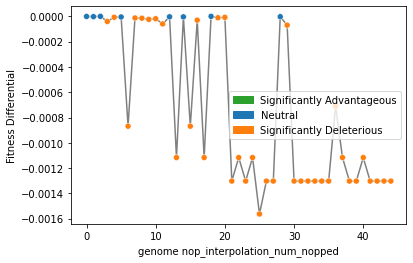

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


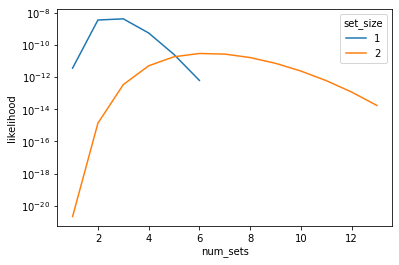

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 6,
    "a=most_credible_likelihood+set_size=1": 4.163073932951797e-09,
    "a=most_credible_likelihood+set_size=2": 2.917851795616431e-11,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 4,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 4.163073932951797e-09,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


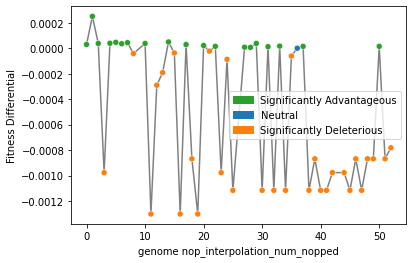

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


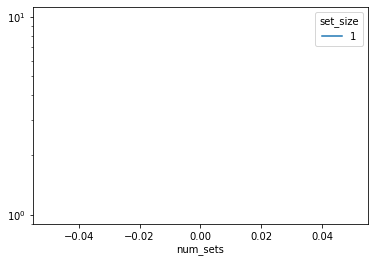

{
    "a=most_credible_idx+set_size=1": NaN,
    "a=most_credible_likelihood+set_size=1": NaN,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


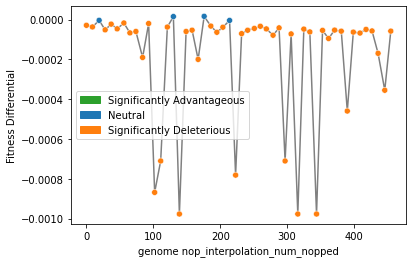

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


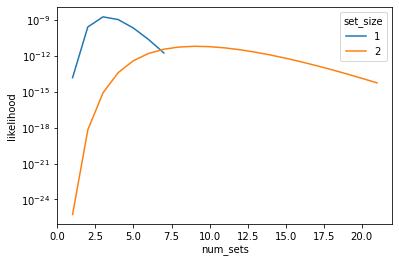

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 9,
    "a=most_credible_likelihood+set_size=1": 1.9372336671340793e-09,
    "a=most_credible_likelihood+set_size=2": 6.610878760245154e-12,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 5,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 1.9372336671340793e-09,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


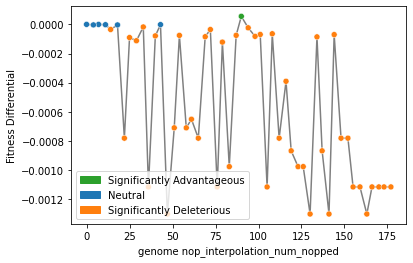

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


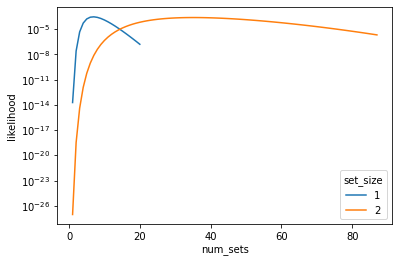

{
    "a=most_credible_idx+set_size=1": 7,
    "a=most_credible_idx+set_size=2": 35,
    "a=most_credible_likelihood+set_size=1": 0.00029496536593592545,
    "a=most_credible_likelihood+set_size=2": 0.00024326081469768182,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 12,
    "interpolation_complexity": 7,
    "most_credible_idx": 7,
    "most_credible_likelihood": 0.00029496536593592545,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


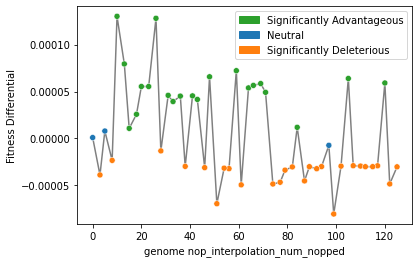

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


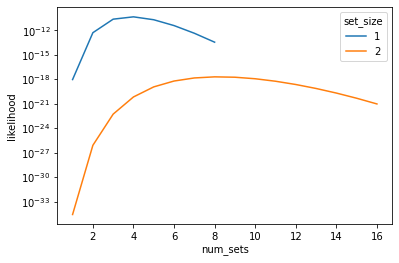

{
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 8,
    "a=most_credible_likelihood+set_size=1": 4.671064647304225e-11,
    "a=most_credible_likelihood+set_size=2": 2.0092125021260122e-18,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 6,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 4.671064647304225e-11,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


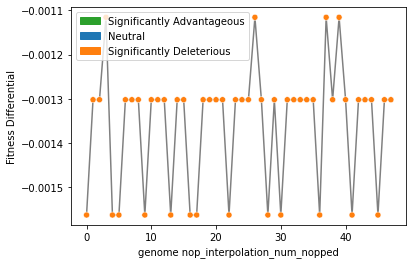

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


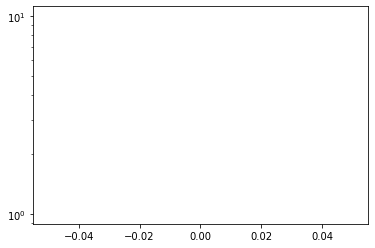

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


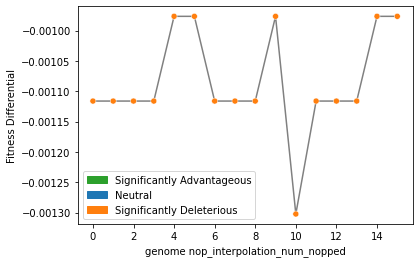

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


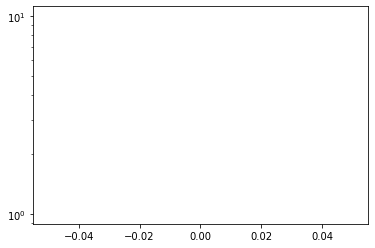

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


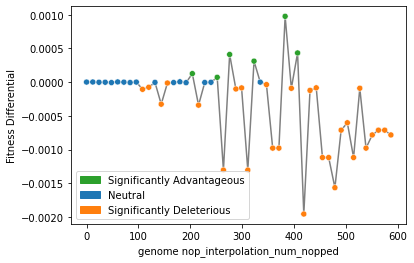

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


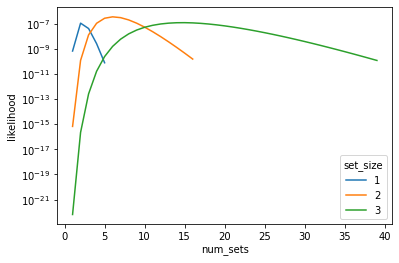

{
    "a=most_credible_idx+set_size=1": 2,
    "a=most_credible_idx+set_size=2": 6,
    "a=most_credible_idx+set_size=3": 15,
    "a=most_credible_likelihood+set_size=1": 1.0989128531926858e-07,
    "a=most_credible_likelihood+set_size=2": 3.501721752974872e-07,
    "a=most_credible_likelihood+set_size=3": 1.2031807643229567e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 10,
    "interpolation_complexity": 6,
    "most_credible_idx": 6,
    "most_credible_likelihood": 3.501721752974872e-07,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


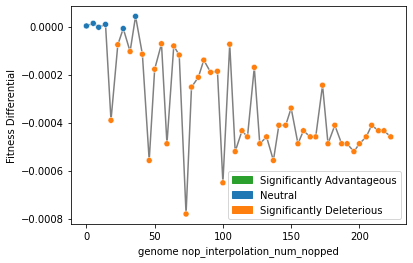

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


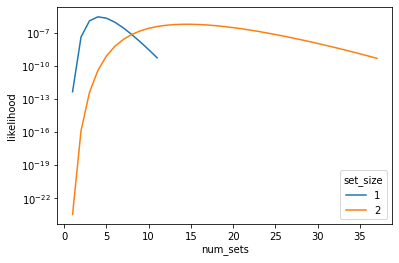

{
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 15,
    "a=most_credible_likelihood+set_size=1": 2.6124970701570574e-06,
    "a=most_credible_likelihood+set_size=2": 5.568296723722123e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 7,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 2.6124970701570574e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


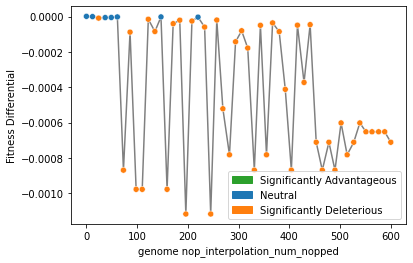

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


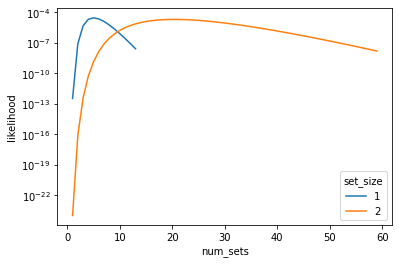

{
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 20,
    "a=most_credible_likelihood+set_size=1": 2.864474067603515e-05,
    "a=most_credible_likelihood+set_size=2": 2.00109530179764e-05,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 8,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 2.864474067603515e-05,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


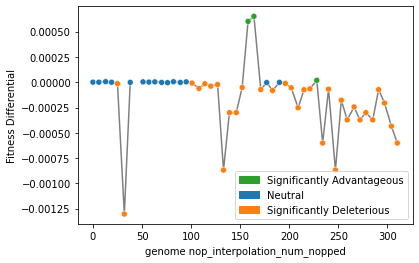

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


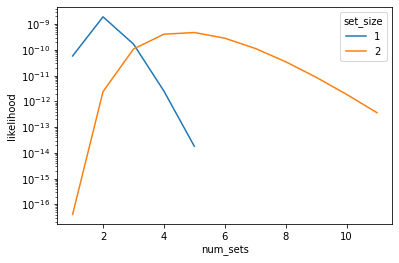

{
    "a=most_credible_idx+set_size=1": 2,
    "a=most_credible_idx+set_size=2": 5,
    "a=most_credible_likelihood+set_size=1": 1.916169466895238e-09,
    "a=most_credible_likelihood+set_size=2": 4.718157828773317e-10,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 3,
    "interpolation_complexity": 2,
    "most_credible_idx": 2,
    "most_credible_likelihood": 1.916169466895238e-09,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


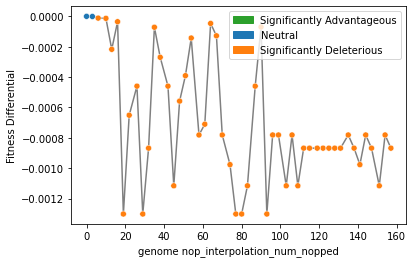

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


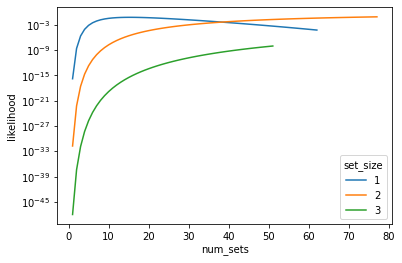

{
    "a=most_credible_idx+set_size=1": 15,
    "a=most_credible_idx+set_size=2": 77,
    "a=most_credible_idx+set_size=3": 51,
    "a=most_credible_likelihood+set_size=1": 0.05687973403565211,
    "a=most_credible_likelihood+set_size=2": 0.07375278382808442,
    "a=most_credible_likelihood+set_size=3": 9.004122289435617e-09,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 45,
    "credible_interval_upper_bound_idx": 77,
    "interpolation_complexity": 77,
    "most_credible_idx": 77,
    "most_credible_likelihood": 0.07375278382808442,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


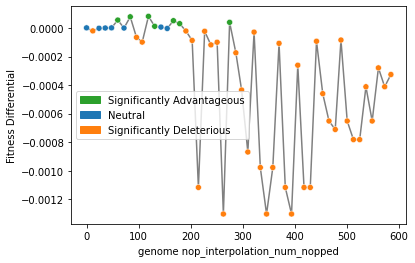

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


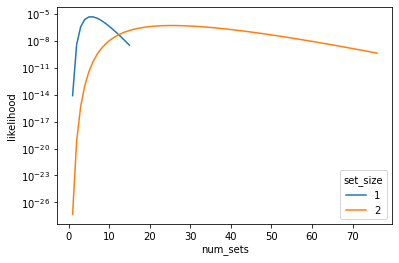

{
    "a=most_credible_idx+set_size=1": 6,
    "a=most_credible_idx+set_size=2": 26,
    "a=most_credible_likelihood+set_size=1": 5.0150391068852846e-06,
    "a=most_credible_likelihood+set_size=2": 5.372527961219357e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 10,
    "interpolation_complexity": 6,
    "most_credible_idx": 6,
    "most_credible_likelihood": 5.0150391068852846e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


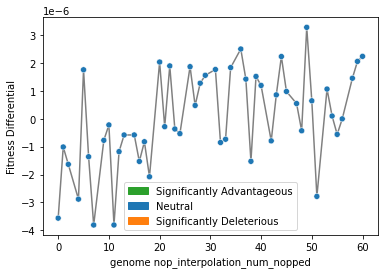

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


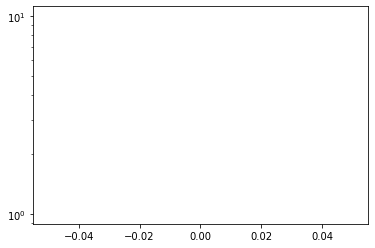

{
    "all_nopped_is_less_fit": false,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


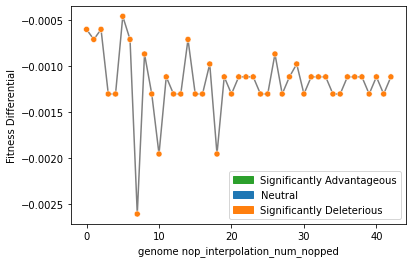

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


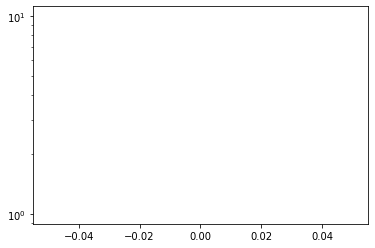

{
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


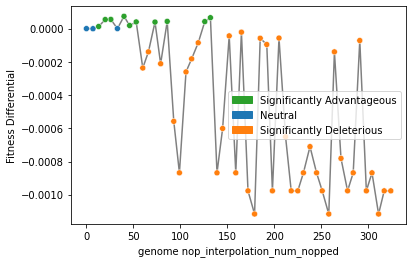

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


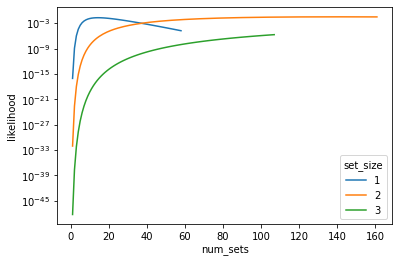

{
    "a=most_credible_idx+set_size=1": 14,
    "a=most_credible_idx+set_size=2": 141,
    "a=most_credible_idx+set_size=3": 107,
    "a=most_credible_likelihood+set_size=1": 0.021388170651723448,
    "a=most_credible_likelihood+set_size=2": 0.034617618092738535,
    "a=most_credible_likelihood+set_size=3": 2.0851739750702805e-06,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 65,
    "credible_interval_upper_bound_idx": 161,
    "interpolation_complexity": 141,
    "most_credible_idx": 141,
    "most_credible_likelihood": 0.034617618092738535,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+_dfdigest=-7517923449d93617+ext=.png


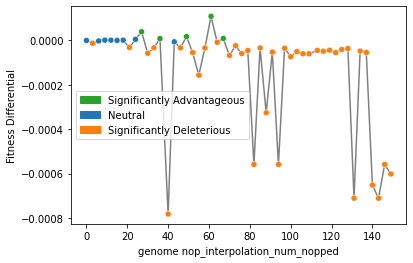

teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+viz=log-lineplot+x=num-sets+y=likelihood+_dfdigest=-7517923449d93617+ext=.png


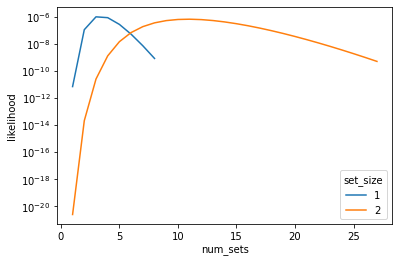

{
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 11,
    "a=most_credible_likelihood+set_size=1": 1.045577153012517e-06,
    "a=most_credible_likelihood+set_size=2": 6.986458325608786e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 5,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 1.045577153012517e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


In [11]:
# display(HTML("<style>div.output_scroll { height: 1000em; }</style>"))

for series in df['genome series'].unique():
    
    display(HTML(f'<h1>series {series}</h1>'))
    

    display(HTML('<h2>interpolation competition</h2>'))
    tp.tee(
        lineplot_scatterplot,
        x='genome nop_interpolation_num_nopped',
        y='Fitness Differential',
        hue='Relative Fitness',
        data=df[df['genome series'] == series].dropna(subset=['genome nop_interpolation_num_nopped']),
        teeplot_outattrs={
            'bucket' : ib.dub( df['Treatment bucket'] ),
            'endeavor' : ib.dub( df['Competition Endeavor'] ),
            '_dfdigest' : dfdigest,
        },
    )
    plt.show()
    
    

    display(HTML('<h2>num_sets fitting</h2>'))
    tp.tee(
        log_lineplot,
        x='num_sets',
        y='likelihood',
        hue='set_size',
        data=calc_loglikelihoods_over_set_sizes(
            series=series,
            interpolation_competitions_df=df,
        ).astype({
            # so seaborn will color as categorical, not quantitative
            'set_size': 'str',
        }),
        teeplot_outattrs={
            'bucket' : ib.dub( df['Treatment bucket'] ),
            'endeavor' : ib.dub( df['Competition Endeavor'] ),
            '_dfdigest' : dfdigest,
        },
    )
    plt.show()
    
    display(HTML('<h2>model fit results</h2>'))
    print(json.dumps(
        estimate_interpolation_complexity(
            series=series,
            interpolation_competitions_df=df,
        ),
        sort_keys=True,
        indent=4,
    ))